In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from pandas.tseries.offsets import MonthEnd

In [2]:
%run -i financial_sector_functions.py

/home/luke/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def return_function(df):
    if type(df)!=pd.DataFrame:
        df = pd.DataFrame(df)
    out_df = (df.shift(-1)-df)/df
    return out_df

In [4]:
data = pd.read_csv("financial_sector_clean_return_space_Dec_13.csv")
data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
data = data.iloc[:,1:]

sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
sp500 = sp500.iloc[:,[1]]
sp500 = return_function(sp500)
sector_return = data.iloc[:,[0]]
x_data = data.iloc[:,1:]
sector_return,x_data = model_data(sector_return,x_data)
sector_return,sp500 = model_data(sector_return,sp500)

# sector_beat_benchmark = pd.DataFrame((sector_return.values > sp500.values)*1,index = sector_return.index,columns = ['IFY beat benchmark'])

In [4]:
# data = pd.read_csv("financial_sector_clean_return_space.csv")
# data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
# data = data.iloc[:,1:]

In [5]:
# sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
# sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
# sp500 = sp500.iloc[:,[1]]
# sp500 = return_function(sp500)

In [15]:
# sector_return,sp500 = model_data(sector_return,sp500)
# sector_beat_benchmarks = pd.DataFrame((sector_return.values > sp500.values)*1,index = sector_return.index, columns = sector_return.columns)

In [6]:
# sector_return = data.iloc[:,[0]]
# x_data = pd.concat([data.iloc[:,1:],sp500],1)
# sector_return,x_data = model_data(sector_return,x_data)

In [5]:
x = x_data
y = sector_return
linear = sm.OLS(y, x)
results = linear.fit()

y_predict = pd.DataFrame(results.predict(x),index = x.index)
metric_value = evaluate_metric(y,y_predict,'r2')
print(metric_value)

0.814935878103


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [6]:
x=x_data
y=sector_beat_benchmarks

# nunmber_of_years_lookback = 5
# month_forecast = 3

lin_overall_df = pd.DataFrame()
for nunmber_of_years_lookback in range(3,11+1):
    for month_forecast in range(3,12+1):
        logistic_result_dict = {}
        coef_all_df = pd.DataFrame()
        accuracy_dict = {}
        y_prediction_dict ={}
        prob_dict ={}
        number_of_runs = 0.0
        for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
            begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
            selection = (x.index>=begin_index) & (x.index <= end_index)
            spliced_x = x[selection]
            spliced_y = y[selection]

            assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
            linear = sm.OLS(y, x)
            results = linear.fit()

            test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
            test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
            test_x = x[test_selection]
            test_y = y[test_selection]
            assert(len(test_y)==month_forecast)
            y_prediction = pd.DataFrame(results.predict(test_x),index = test_x.index)
            y_prediction_dict[dt_index] = y_prediction
            linear_result = [1.0 if prob>0.5 else 0.0 for prob in results.predict(test_x)]
            linear_result_df = pd.DataFrame(linear_result,index = test_x.index)
            accuracy_value = evaluate_metric(test_y,linear_result_df,'acf')
            accuracy_dict[dt_index] = accuracy_value

        mean_accuracy_list = []
        for key,value in accuracy_dict.iteritems():
            mean_accuracy_list.append(value)

        lin_reg_acc = np.mean(mean_accuracy_list)
        

        lin_overall_df.loc[str(nunmber_of_years_lookback)+" years",str(month_forecast)+" months"]=lin_reg_acc

NameError: name 'sector_beat_benchmarks' is not defined

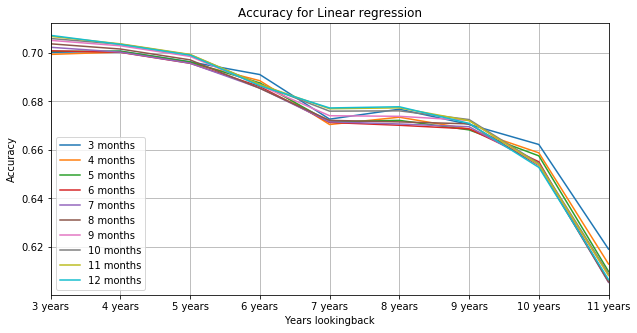

In [54]:
lin_overall_df.plot(figsize=(10,5))
plt.grid()
plt.xlabel("Years lookingback")
plt.ylabel("Accuracy")
plt.title("Accuracy for Linear regression")
plt.savefig("Linear_regression_param.png")
plt.show()

In [47]:
np.max(lin_overall_df.values)

0.70722222222222231

In [40]:
concat_df = pd.DataFrame()
for key in np.sort(y_prediction_dict.keys()):
    value = y_prediction_dict[key]
    concat_df = pd.concat([concat_df,value],1)
clean_df = pd.DataFrame()
for index in concat_df.index:
    temp = concat_df.loc[index,:].dropna()
    temp = pd.DataFrame(temp).T
    temp.columns = range(len(temp.columns))
    clean_df = pd.concat([clean_df,temp])

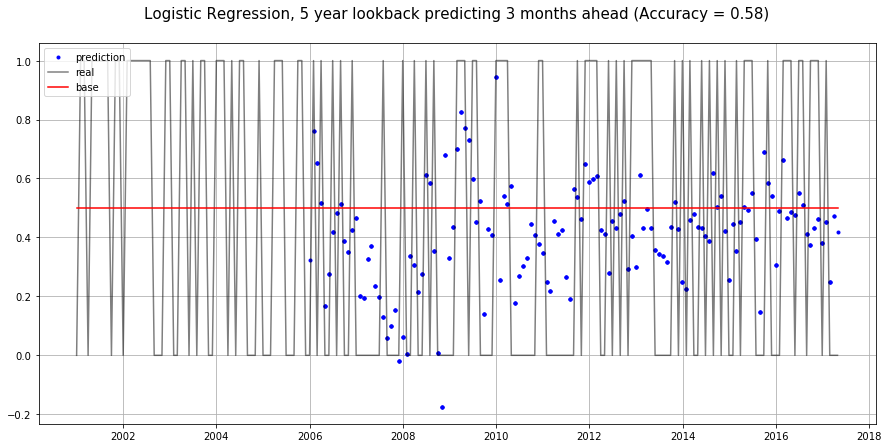

In [42]:
clean_df


plt.figure(figsize = (15,7))
plt.grid()
pred_1,pred_2,pred_3,=plt.plot(clean_df,'b.')
real_y,=plt.plot(y,'k-',alpha = 0.5)
base,=plt.plot(y.index,np.repeat(0.5,len(y)),'r-')
plt.legend([pred_1,real_y,base],['prediction','real','base'],loc=2)
ttl = plt.title("Linear Regression, 5 year lookback predicting 3 months ahead (Accuracy = 0.58)",fontsize = 15)
ttl.set_position([.5, 1.05])
plt.savefig("linear_regression_5year_3months_result.png")
plt.show()

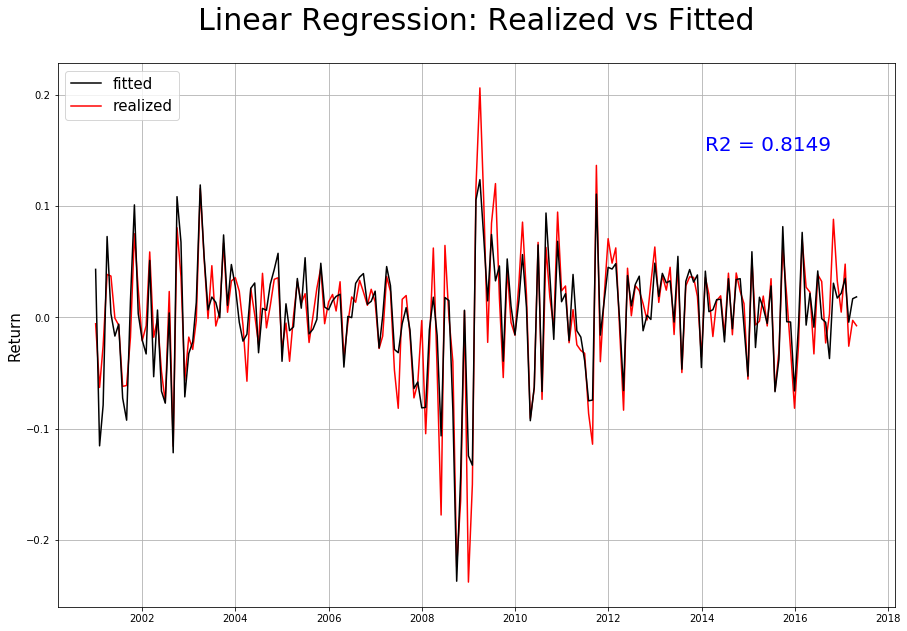

In [10]:
file_dir = '/home/luke/workspace/Sector-Analysis/Luke_working_space/Plot generating codes/linear_regression/'

plt.figure(figsize = (15,10))
ttl = plt.title("Linear Regression: Realized vs Fitted",size = 30)
ttl.set_position([.5, 1.05])
real,=plt.plot(y,'r-')
fit,=plt.plot(y_predict,'k-')
plt.text(y.index[-40],0.15,'R2 = '+str(round(metric_value,4)),size=20,color='b')
plt.legend([fit,real],['fitted','realized'],loc=2,fontsize=15)
plt.ylabel("Return",size=15)
plt.grid()
plt.savefig(file_dir+'linear_regression_additional_data.png',bbox_inches='tight')
plt.show()


In [11]:
econ_data = pd.read_csv("fin_clean_only_econ.csv")
econ_data.index = pd.DatetimeIndex(econ_data.iloc[:,[0]].values.flatten())
econ_data = econ_data.iloc[:,1:]
econ_data.columns

Index([u'IYF US Equity', u'GDP', u'DGS10', u'TEDRATE', u'YIELD_SLOPE',
       u'PAYEMS', u'VIXCLS', u'CSUSHPINSA', u'RECPROUSM156N', u'UNRATE',
       u'FEDFUNDS', u'PCE', u'BAMLH0A0HYM2', u'NETEXP', u'UMCSENT',
       u'XAU Curncy', u'XOI Index'],
      dtype='object')

In [12]:
sector_return = econ_data.iloc[:,[0]]
econ_x_data = pd.concat([econ_data.iloc[:,1:],sp500],1)
sector_return,econ_x_data = model_data(sector_return,x_data)

In [13]:
x = econ_x_data
y = sector_return
linear = sm.OLS(y, x)
results = linear.fit()

y_predict = pd.DataFrame(results.predict(x),index = x.index)
metric_value = evaluate_metric(y,y_predict,'r2')
print(metric_value)

0.814935878103


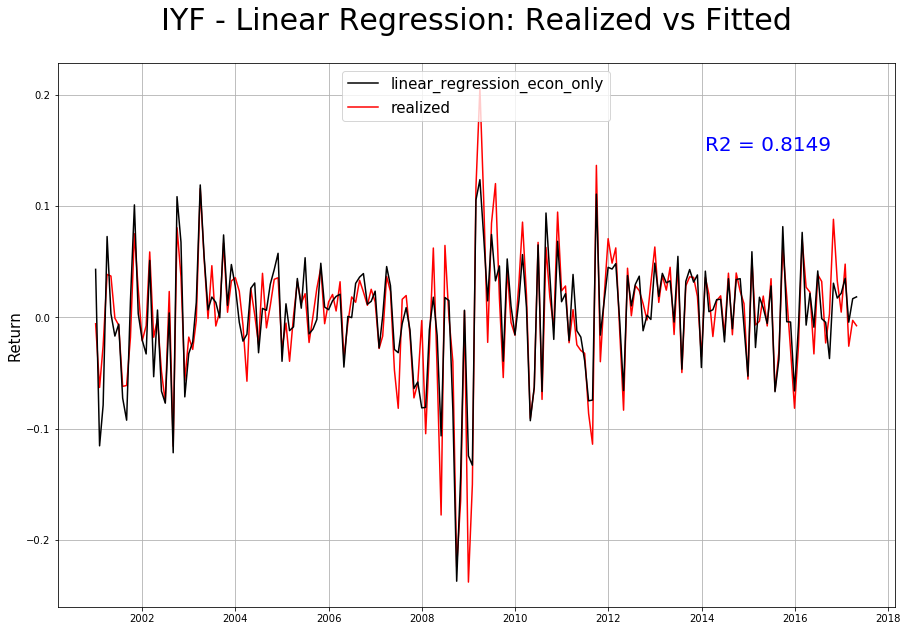

In [14]:
plt.figure(figsize = (15,10))
ttl = plt.title("IYF - Linear Regression: Realized vs Fitted",size = 30)
ttl.set_position([.5, 1.05])
real,=plt.plot(y,'r-')
fit,=plt.plot(y_predict,'k-')
plt.text(y.index[-40],0.15,'R2 = '+str(round(metric_value,4)),size=20,color='b')
plt.legend([fit,real],['linear_regression_econ_only','realized'],loc=9,fontsize=15)
plt.ylabel("Return",size=15)
plt.grid()
plt.savefig('foo2.png',bbox_inches='tight')
plt.show()
